# QuTiPv5 Paper Example: `sesolve` and `mesolve` and the new solver class

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Neill Lambert (nwlambert@gmail.com), Paul Menczel (paul@menczel.net)

In QuTiP, the `Qobj` and `QobjEvo` classes form the very heart of almost all calculations that can be performed.
With these classes, open quantum systems with various interactions and structures can be simulated by using the wide variety of solvers provided.
Most of the time, these solvers are given an initial state, a Hamiltonian and an environment that is often described using rates or coupling strengths.
QuTiP then uses numerical integration to determine the time evolution of the system.

QuTiP v5 [\[1\]](#references) introduces a unified interface for interacting with these solvers.
This new interface is class-based, allowing users to instantiate a solver object for a specific problem.
This can be useful when the same Hamiltonian data is reused with different initial conditions, time steps or other options.
A noticable speed-up can thus be achieved if solvers are reused multiple times.

Upon instantiation, one first supplies only the Hamiltonian and the collapse operators (e.g., collapse operators for a Lindbladian master equation).
Initial conditions, time steps, etc. are passed to the `Solver.run()` method which then performs the simulation.

In this notebook we will consider several examples illustrating the usage of the new solver classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (
    QobjEvo,
    SESolver,
    UnderDampedEnvironment,
    about,
    basis,
    brmesolve,
    fidelity,
    mesolve,
    qeye,
    sigmam,
    sigmax,
    sigmaz,
    spost,
    spre,
    sprepost,
)
from qutip.solver.heom import HEOMSolver

%matplotlib inline

## Part 0: Introduction to the New Solver Class

In our first example, we want to look at two interacting qubits that are (for now) decoupled from an environment.
Such a system is described by the Hamiltonian

$$H = \dfrac{\epsilon_1}{2} \sigma_z^{(1)} + \dfrac{\epsilon_2}{2} \sigma_z^{(2)} + g \sigma_{x}^{(1)} \sigma_{x}^{(2)}.$$

The Pauli matrices $\sigma_z^{(1/2)}$ describe the respective two-level system of the qubits.
The qubits are coupled via $\sigma_{x}^{(1/2)}$ and their interaction strength is given by $g$.

In [2]:
epsilon1 = 1.0
epsilon2 = 1.0
g = 0.1

sx1 = sigmax() & qeye(2)
sx2 = qeye(2) & sigmax()
sz1 = sigmaz() & qeye(2)
sz2 = qeye(2) & sigmaz()

H = (epsilon1 / 2) * sz1 + (epsilon2 / 2) * sz2 + g * sx1 * sx2

print(H)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.   0.   0.   0.1]
 [ 0.   0.   0.1  0. ]
 [ 0.   0.1  0.   0. ]
 [ 0.1  0.   0.  -1. ]]


The dynamics of such a system is described by the Schrödinger equation

$$i \hbar \dfrac{d}{dt} \ket{\psi} = H \ket{\psi}.$$

Therefore, we can use `SESolver` to calculate the dynamics.

In [3]:
se_solver = SESolver(H)
psi0 = basis(2, 0) & basis(2, 1)
tlist = np.linspace(0, 40, 100)

In [4]:
se_res = se_solver.run(psi0, tlist, e_ops=[sz1, sz2])

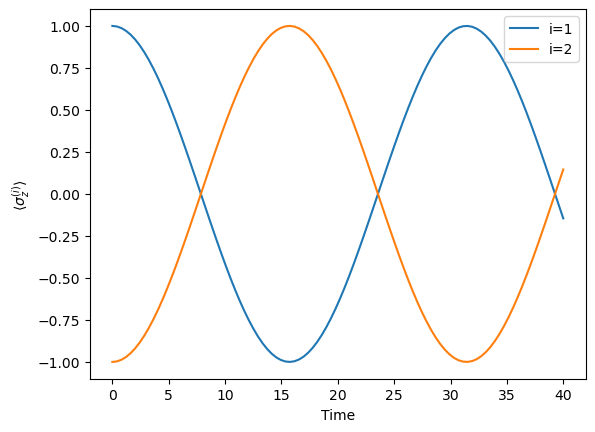

In [5]:
plt.plot(tlist, se_res.expect[0], label="i=1")
plt.plot(tlist, se_res.expect[1], label="i=2")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(i)} \rangle$")
plt.legend()
plt.show()

### Solver and Integrator Options

Another change in QuTiP v5 is that the `options` argument takes a standard Python dictionary.
This should increase future flexibility and allow different solvers to provide individual sets of options more easily.
The complete list of options can be found in the online documentation for each solver.

As an example of frequently used options, we show `store_states`, determining whether the output should include the system state at each time step, and `store_final_state`, determining the same but for the final state.
`method` is another common option, specifying the ODE integration method.
Specific options related to the numeric integration depend on the chosen method; here, we show `atol` controlling the precision (absolute tolerance),
`nsteps` controlling the maximum number of steps between two time steps, and `max_step` giving the maximum allowed integration step of the default Adams ODE integration method.

In [6]:
options = {"store_states": True, "atol": 1e-12, "nsteps": 1e3, "max_step": 0.1}
se_solver.options = options

In [7]:
se_res = se_solver.run(psi0, tlist)

In [8]:
print(se_res)

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00013446807861328125
    preparation time: 0.00016069412231445312
    run time: 0.0032012462615966797
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 40.0] (100 steps)
  Number of e_ops: 0
  States saved.
>


## Part 1: Lindblad Dynamics and Beyond

In general, the Schrödinger equation describes the dynamics of any quantum system.
Once systems become large or we consider continuous systems, however, solving it often becomes impossible.
Therefore, master equations of various types were developed and have now become the most common way to describe the dynamics of finite (open) quantum systems.
Generally, a master equation refers to a first-order linear differential equation for $\rho(t)$ which is the reduced density operator describing the quantum state.
In QuTiP, `mesolve` is the general solver we use to solve such master equations.
Although it supports master equations of various forms, the Lindbladian type is implemented by default.
The general form of such an equation is given by

$$ \dot{\rho}(t) = - \dfrac{i}{\hbar} [H(t), \rho(t)] + \sum_n \dfrac{1}{2}[ 2 C_n \rho(t) C_n^\dagger - \rho(t) C_n^\dagger C_n - C^\dagger_n C_n \rho(t) ] . $$

Next to the density operator $\rho(t)$ and the Hamiltonian $H(t)$, this equation includes the so-called collapse (or jump) operators $C_n = \sqrt{\gamma_n} A_n$.
They define the dissipation due to contact with an environment.
The rates $\gamma_n$ describe the frequency of transitions between the states connected by the operator $A_n$.

To continue our example of the two qubits, we now connect them to an evironment using the collapse operators $C_1 = \sqrt{\gamma} \sigma_{-}^{(1)}$ and $C_2 = \sqrt{\gamma} \sigma_{-}^{(2)}$ where $\sigma_{-}^{(i)}$ takes qubit (i) from its excited state to its ground state.
This time, however, we will be using the `mesolve` solver.

In [9]:
sm1 = sigmam() & qeye(2)
sm2 = qeye(2) & sigmam()
gam = 0.1  # dissipation rate
c_ops = [np.sqrt(gam) * sm1, np.sqrt(gam) * sm2]

In [10]:
me_local_res = mesolve(H, psi0, tlist, c_ops, e_ops=[sz1, sz2])

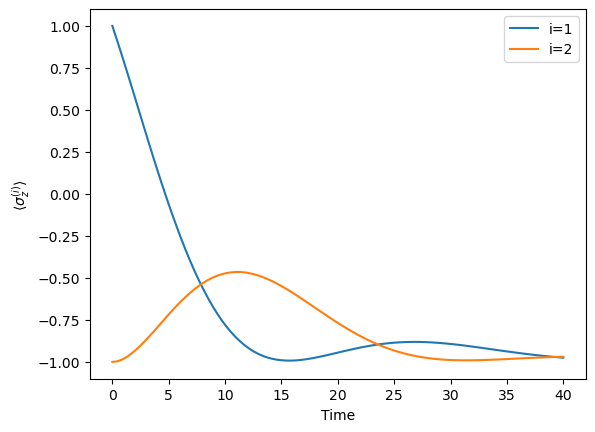

In [11]:
plt.plot(tlist, me_local_res.expect[0], label="i=1")
plt.plot(tlist, me_local_res.expect[1], label="i=2")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(i)} \rangle$")
plt.legend()
plt.show()

### Global Master Equation - Born-Markov-secular approximation

In the previous example, the collapse operators acted *locally* on each qubit.
However, depending on the considered approximation, different kinds of collapse operators are found.
One example for this is when the qubits interact more strongly with each other than with the bath.
One then arrives at the *global* master equation under the standard Born-Markox approximation.
Although the collapse operators still act like annihilation and creation operators here, they now act on the total coupled eigenstates of the interacting two-qubit system

$$A_{ij} = \ket{\psi_i}\bra{\psi_i}$$

with rates

$$\gamma_{ij} = | \bra{\psi_i} d \ket{\psi_j} |^2 S(\Delta_{ij}).$$

The $\ket{\psi_i}$ are the eigenstates of $H$ and $\Delta_{ij} = E_j - E_i$ are the differences of eigenenergies.
$d$ is the coupling operator of the system to the environment.
We use the power spectrum

$$S(\omega) = 2 J(\omega) [n_{th} (\omega) + 1] \theta(\omega) + 2J(-\omega)[n_{th}(-\omega)]\theta(-\omega)$$

which depends on details of the environment such as its spectral density $J(\omega)$ and, through the Bose-Einstein distribution $n_{th} (\omega)$, its temperature.
$\theta$ denotes the Heaviside function.

By assuming spectral density to be flat, $J(\omega) = \gamma / 2$, and considering zero temperature, we can write

$$S(\omega) = \gamma \theta(\omega).$$

For this example, we manually implement this zero temperature environment for our two-qubit system using `mesolve()`.

In [12]:
def power_spectrum(w):
    if w >= 0:
        return gam
    else:
        return 0


def make_co_list(energies, eigenstates):
    Nmax = len(eigenstates)
    collapse_list = []
    for i in range(Nmax):
        for j in range(Nmax):
            delE = energies[j] - energies[i]
            m1 = sx1.matrix_element(eigenstates[i].dag(), eigenstates[j])
            m2 = sx2.matrix_element(eigenstates[i].dag(), eigenstates[j])
            absolute = np.abs(m1) ** 2 + np.abs(m2) ** 2
            rate = power_spectrum(delE) * absolute
            if rate > 0:
                outer = eigenstates[i] * eigenstates[j].dag()
                collapse_list.append(np.sqrt(rate) * outer)
    return collapse_list

In [13]:
all_energy, all_state = H.eigenstates()
collapse_list = make_co_list(all_energy, all_state)
tlist_long = np.linspace(0, 1000, 100)

In [14]:
opt = {"store_states": True}
me_global_res = mesolve(
    H, psi0, tlist_long, collapse_list, e_ops=[sz1, sz2], options=opt
)

It is interesting to note that the long-time evolution leads to a state that is close to the coupled ground state of the two qubit system:

In [15]:
grnd_state = all_state[0] @ all_state[0].dag()
fidelity = fidelity(me_global_res.states[-1], grnd_state)
print(f"Fidelity with ground-state: {fidelity:.6f}")

Fidelity with ground-state: 1.000000


### Solver comparison

In the following, we compare the results of the local and dressed (global) Lindblad simulations from above with the Bloch-Redfield solver.
The Bloch-Redfield solver is explained in more detail in other tutorials, but we use it here to solve the weak-coupling master equation from a given bath power spectrum.
For small coupling strengths, the results from the local and global master equations both agree with the Bloch-Redfield solver.
However, this changes when considering stronger couplings where the local master equation deviates from the result of the global and the Bloch-Redfield approach.

In [16]:
# weak coupling
g = 0.1 * epsilon1
H_weak = (epsilon1 / 2) * sz1 + (epsilon2 / 2) * sz2 + g * sx1 * sx2

In [17]:
# generate new collapse operators for weak coupling Hamiltonian
all_energy, all_state = H_weak.eigenstates()
co_list = make_co_list(all_energy, all_state)

In [18]:
me_local_res = mesolve(H_weak, psi0, tlist, c_ops, e_ops=[sz1, sz2])
me_global_res = mesolve(H_weak, psi0, tlist, co_list, e_ops=[sz1, sz2])
br_res = brmesolve(
    H_weak,
    psi0,
    tlist,
    e_ops=[sz1, sz2],
    a_ops=[[sx1, power_spectrum], [sx2, power_spectrum]],
)

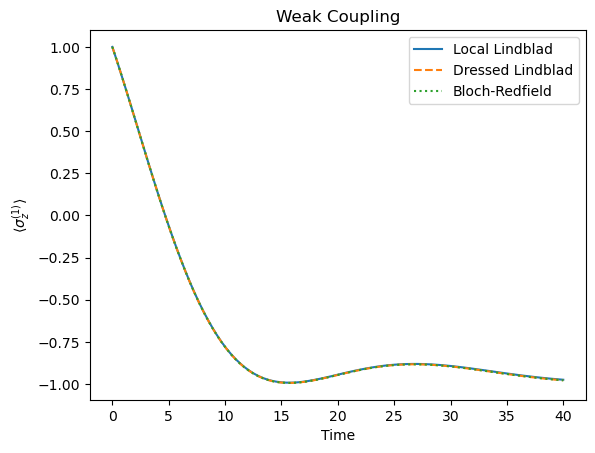

In [19]:
plt.plot(tlist, me_local_res.expect[0], label=r"Local Lindblad")
plt.plot(tlist, me_global_res.expect[0], "--", label=r"Dressed Lindblad")
plt.plot(tlist, br_res.expect[0], ":", label=r"Bloch-Redfield")
plt.title("Weak Coupling")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(1)} \rangle$")
plt.legend()
plt.show()

In [20]:
# strong coupling
g = 2 * epsilon1
H_strong = (epsilon1 / 2) * sz1 + (epsilon2 / 2) * sz2 + g * sx1 * sx2

In [21]:
# generate new collapse operators for weak coupling Hamiltonian
all_energy, all_state = H_strong.eigenstates()
co_list = make_co_list(all_energy, all_state)

# time list with smaller steps
tlist_fine = np.linspace(0, 40, 1000)

In [22]:
me_local_res = mesolve(H_strong, psi0, tlist_fine, c_ops, e_ops=[sz1, sz2])
me_global_res = mesolve(H_strong, psi0, tlist_fine, co_list, e_ops=[sz1, sz2])
br_res = brmesolve(
    H_strong,
    psi0,
    tlist_fine,
    e_ops=[sz1, sz2],
    a_ops=[[sx1, power_spectrum], [sx2, power_spectrum]],
)

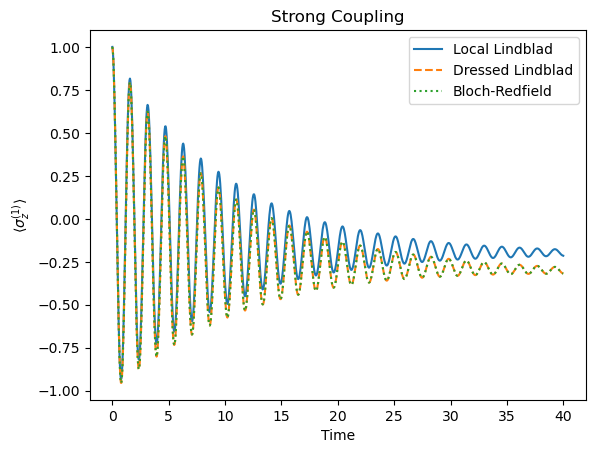

In [23]:
plt.plot(tlist_fine, me_local_res.expect[0], label=r"Local Lindblad")
plt.plot(tlist_fine, me_global_res.expect[0], "--", label=r"Dressed Lindblad")
plt.plot(tlist_fine, br_res.expect[0], ":", label=r"Bloch-Redfield")
plt.title("Strong Coupling")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(1)} \rangle$")
plt.legend()
plt.show()

### Manual Liouvillian Superoperator

As mentioned before, QuTiP's master equation solver can be used to solve any other master equation.
By using `spre()`, `spost()` and `sprepost()`, we can manually construct such equations.
These functions specifically convert the operators from the original Hilbert space to operators in the double space which is internally used by QuTiP to optimize computations (more details on this can be found in the [QuTiPv5 paper](#References)).

For example, the Lindbladian corresponding to the master equation of the previous example can be constructed manually via:


In [24]:
lindbladian = -1.0j * (spre(H) - spost(H))
for c in c_ops:
    lindbladian += sprepost(c, c.dag())
    lindbladian -= 0.5 * (spre(c.dag() * c) + spost(c.dag() * c))

In [25]:
manual_res = mesolve(lindbladian, psi0, tlist_fine, [], e_ops=[sz1, sz2])

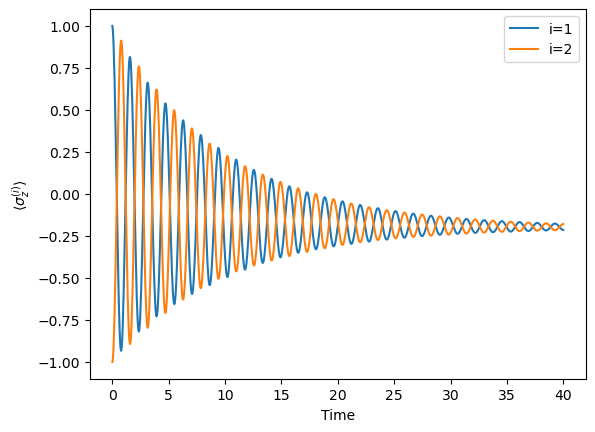

In [26]:
plt.plot(tlist_fine, me_local_res.expect[0], label="i=1")
plt.plot(tlist_fine, me_local_res.expect[1], label="i=2")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(i)} \rangle$")
plt.legend()
plt.show()

## Part 2: Time-Dependent Systems

Finally, we compare the results from another example, that of a driven system using, first, `mesolve()` with and without the rotating-wave approximation (RWA) for the drive, and then without RWA with the Bloch-Redfield and HEOM solvers.
For this, we consider a Hamiltonian of the form

$$ H = \frac{\Delta}{2} \sigma_z + \frac{A}{2} \sin (\omega_d t) \sigma_x , $$

where $\Delta$ is the energy splitting, $A$ is the drive amplitude and $\omega_d$ is the drive's frequency.

In [27]:
# Hamiltonian parameters
Delta = 2 * np.pi  # qubit splitting
omega_d = Delta  # drive frequency
A = 0.01 * Delta  # drive amplitude

# Bath parameters
gamma = 0.005 * Delta / (2 * np.pi)  # dissipation strength
temp = 0  # temperature

# Simulation parameters
psi0 = basis(2, 0)  # initial state
e_ops = [sigmaz()]
T = 2 * np.pi / omega_d  # period length
tlist = np.linspace(0, 1000 * T, 500)

### With `mesolve`

In [28]:
# driving field
def f(t):
    return np.sin(omega_d * t)

In [29]:
H0 = Delta / 2.0 * sigmaz()
H1 = [A / 2.0 * sigmax(), f]
H = [H0, H1]

In [30]:
c_ops_me = [np.sqrt(gamma) * sigmam()]

In [31]:
driv_res = mesolve(H, psi0, tlist, c_ops=c_ops_me, e_ops=e_ops)

### With Rotating-Wave-Approximated `mesolve`

In [32]:
H_RWA = (Delta - omega_d) * 0.5 * sigmaz() + A / 4 * sigmax()
c_ops_me_RWA = [np.sqrt(gamma) * sigmam()]

In [33]:
driv_RWA_res = mesolve(H_RWA, psi0, tlist, c_ops=c_ops_me_RWA, e_ops=e_ops)

### With `brmesolve`

In [34]:
# Bose einstein distribution
def nth(w):
    if temp > 0:
        return 1 / (np.exp(w / temp) - 1)
    else:
        return 0


# Power spectrum
def power_spectrum(w):
    if w > 0:
        return gamma * (nth(w) + 1)
    elif w == 0:
        return 0
    else:
        return gamma * nth(-w)

In [35]:
a_ops = [[sigmax(), power_spectrum]]

In [36]:
driv_br_res = brmesolve(H, psi0, tlist, a_ops, sec_cutoff=-1, e_ops=e_ops)

### With `HEOMSolver`

In [37]:
max_depth = 4  # number of hierarchy levels

wsamp = 2 * np.pi
w0 = 5 * 2 * np.pi
gamma_heom = 1.9 * w0

lambd = np.sqrt(
    0.5
    * gamma
    * ((w0**2 - wsamp**2) ** 2 + (gamma_heom**2) * ((wsamp) ** 2))
    / (gamma_heom * wsamp)
)

In [38]:
# Create Environment
bath = UnderDampedEnvironment(lam=lambd, w0=w0, gamma=gamma_heom, T=0)
fit_times = np.linspace(0, 5, 1000)  # range for correlation function fit

# Fit correlation function with exponentials
exp_bath, fit_info = bath.approx_by_cf_fit(
    fit_times, Ni_max=1, Nr_max=2, target_rmse=None
)
print(fit_info["summary"])

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 2 terms:                    |of the correlation function with 1 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |  vki                   | Parameters|   ckr    |   vkr    |  vki                    
 1         | 2.29e-02 |-7.48e+00 |1.80e+01                | 1         |-3.53e-01 |-2.98e+01 |9.81e+00                 
 2         | 4.89e-02 |-1.85e+01 |3.41e+01                |                                                           
                                                          |A RMSE of  5.55e-06 was obtained for the the imaginary part
A RMSE of  7.48e-03 was obtained for the the real part of |of the correlation function.                               
the correlation funct

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/environment.py:835: FutureWarning: The API has changed. Please use approximate("cf", ...) instead of approx_by_cf_fit(...).
  warnings.warn('The API has changed. Please use approximate("cf", ...)'


In [39]:
HEOM_corr_fit = HEOMSolver(
    QobjEvo(H),
    (exp_bath, sigmax()),
    max_depth=max_depth,
    options={"nsteps": 15000, "rtol": 1e-12, "atol": 1e-12},
)
results_corr_fit = HEOM_corr_fit.run(psi0 * psi0.dag(), tlist, e_ops=e_ops)

10.0%. Run time:   4.22s. Est. time left: 00:00:00:37


20.0%. Run time:   8.45s. Est. time left: 00:00:00:33


30.1%. Run time:  12.67s. Est. time left: 00:00:00:29


40.1%. Run time:  16.90s. Est. time left: 00:00:00:25


50.1%. Run time:  21.13s. Est. time left: 00:00:00:21


60.1%. Run time:  25.35s. Est. time left: 00:00:00:16


70.1%. Run time:  29.58s. Est. time left: 00:00:00:12


80.2%. Run time:  33.80s. Est. time left: 00:00:00:08


90.2%. Run time:  38.04s. Est. time left: 00:00:00:04


100.0%. Run time:  42.18s. Est. time left: 00:00:00:00


Total run time:  42.18s


### Comparison of Solver Results

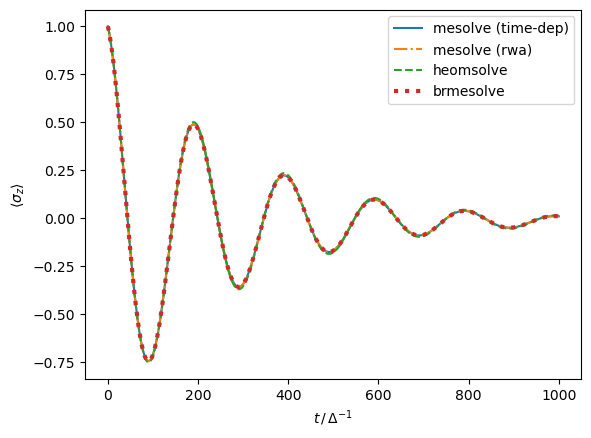

In [40]:
plt.figure()

plt.plot(tlist, driv_res.expect[0], "-", label="mesolve (time-dep)")
plt.plot(tlist, driv_RWA_res.expect[0], "-.", label="mesolve (rwa)")
plt.plot(tlist, np.real(results_corr_fit.expect[0]), "--", label=r"heomsolve")
plt.plot(tlist, driv_br_res.expect[0], ":", linewidth=3, label="brmesolve")

plt.xlabel(r"$t\, /\, \Delta^{-1}$")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.legend()
plt.show()

### Adiabatic Energy Switching

To show where usage of these local-basis collapse operators can lead to errors, we look at a single qubit system.
This time however, the energies of the qubit are adiabatically switched between positive and negative values.

$$H = \dfrac{\Delta}{2} \sin{(\omega_d t)} \sigma_z.$$

If the drive is slow enough, we expect the bath to respond to this change and transitions from higher to lower energy levels should be induced.
These changes in system energy thus have to be taken into account so that `mesolve()` still produces a correct result.

In [41]:
# Hamiltonian
omega_d = 0.05 * Delta  # drive frequency
A = Delta  # drive amplitude
H_adi = [[A / 2.0 * sigmaz(), f]]

# Bath parameters
gamma = 0.05 * Delta / (2 * np.pi)

# Simulation parameters
T = 2 * np.pi / omega_d  # period length
tlist = np.linspace(0, 2 * T, 400)

In [42]:
# Simple mesolve
c_ops_me = [np.sqrt(gamma) * sigmam()]
adi_me_res = mesolve(H_adi, psi0, tlist, c_ops=c_ops_me, e_ops=e_ops)

In [43]:
# HEOM
max_depth = 4  # number of hierarchy levels

wsamp = 2 * np.pi
w0 = 5 * 2 * np.pi
gamma_heom = 1.9 * w0

lambd = np.sqrt(
    0.5
    * gamma
    / (gamma_heom * wsamp)
    * ((w0**2 - wsamp**2) ** 2 + (gamma_heom**2) * ((wsamp) ** 2))
)

In [44]:
# Create Environment
bath = UnderDampedEnvironment(lam=lambd, w0=w0, gamma=gamma_heom, T=0)
fit_times = np.linspace(0, 5, 1000)  # range for correlation function fit

# Fit correlation function with exponentials
exp_bath, fit_info = bath.approx_by_cf_fit(
    fit_times, Ni_max=1, Nr_max=2, target_rmse=None
)
print(fit_info["summary"])

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 2 terms:                    |of the correlation function with 1 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |  vki                   | Parameters|   ckr    |   vkr    |  vki                    
 1         | 1.43e+01 |-2.66e+01 |6.48e+00                | 1         |-3.53e+00 |-2.98e+01 |9.81e+00                 
 2         |-1.35e+01 |-2.70e+01 |2.54e-11                |                                                           
                                                          |A RMSE of  5.55e-06 was obtained for the the imaginary part
A RMSE of  3.66e-03 was obtained for the the real part of |of the correlation function.                               
the correlation funct

In [45]:
HEOM_corr_fit = HEOMSolver(
    QobjEvo(H_adi),
    (exp_bath, sigmax()),
    max_depth=max_depth,
    options={"nsteps": 15000, "rtol": 1e-12, "atol": 1e-12},
)
adi_corr_fit_res = HEOM_corr_fit.run(psi0 * psi0.dag(), tlist, e_ops=e_ops)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01


20.1%. Run time:   0.28s. Est. time left: 00:00:00:01

30.1%. Run time:   0.40s. Est. time left: 00:00:00:00


40.1%. Run time:   0.52s. Est. time left: 00:00:00:00


50.1%. Run time:   0.65s. Est. time left: 00:00:00:00


60.2%. Run time:   0.77s. Est. time left: 00:00:00:00


70.2%. Run time:   0.89s. Est. time left: 00:00:00:00


80.2%. Run time:   1.02s. Est. time left: 00:00:00:00


90.2%. Run time:   1.14s. Est. time left: 00:00:00:00


100.0%. Run time:   1.25s. Est. time left: 00:00:00:00


Total run time:   1.26s


In [46]:
# BRSolve non-flat power spectrum
a_ops_non_flat = [[sigmax(), exp_bath]]
brme_result = brmesolve(H_adi, psi0, tlist, a_ops=a_ops_non_flat, e_ops=e_ops)

In [47]:
# BRSolve
a_ops = [[sigmax(), power_spectrum]]
brme_result2 = brmesolve(H_adi, psi0, tlist, a_ops=a_ops, e_ops=e_ops)

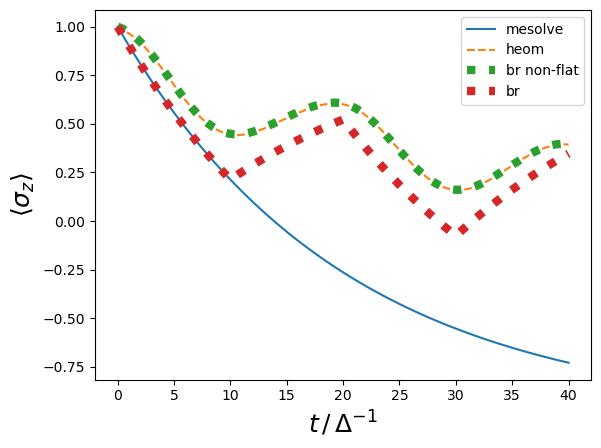

In [48]:
plt.plot(tlist, adi_me_res.expect[0], "-", label="mesolve")
plt.plot(tlist, np.real(adi_corr_fit_res.expect[0]), "--", label=r"heom")
plt.plot(tlist, brme_result.expect[0], ":", linewidth=6, label="br non-flat")
plt.plot(tlist, brme_result2.expect[0], ":", linewidth=6, label="br")

plt.xlabel(r"$t\, /\, \Delta^{-1}$", fontsize=18)
plt.ylabel(r"$\langle \sigma_z \rangle$", fontsize=18)
plt.legend()
plt.show()

## References

\[1\] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

## About

In [49]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [50]:
br_exp = br_res.expect[0]
mg_exp = me_global_res.expect[0]
np.testing.assert_allclose(br_exp, mg_exp, atol=0.02, rtol=0)

d_exp = driv_res.expect[0]
dr_exp = driv_RWA_res.expect[0]
rc_exp = np.real(results_corr_fit.expect[0])
db_exp = driv_br_res.expect[0]
np.testing.assert_allclose(d_exp, dr_exp, atol=0.01, rtol=0)
np.testing.assert_allclose(dr_exp, rc_exp, atol=0.02, rtol=0)
np.testing.assert_allclose(rc_exp, db_exp, atol=0.02, rtol=0)
np.testing.assert_allclose(db_exp, d_exp, atol=0.01, rtol=0)